In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

Importando dados

In [5]:
df = pd.read_csv('sinesp_2015_2025_consolidado.csv')

C:\Users\Cartesius\AppData\Local\Temp\ipykernel_13544\1148182971.py:1: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('sinesp_2015_2025_consolidado.csv')


In [6]:
df['evento'].value_counts()

evento
Mandado de prisão cumprido                                            730729
Feminicídio                                                           730083
Lesão corporal seguida de morte                                       730083
Homicídio doloso                                                      730083
Mortes a esclarecer (sem indício de crime)                            730083
Morte no trânsito ou em decorrência dele (exceto homicídio doloso)    730083
Suicídio                                                              730083
Roubo seguido de morte (latrocínio)                                   730083
Tentativa de homicídio                                                730083
Tentativa de feminicídio                                              727639
Suicídio de Agente do Estado                                           31473
Morte de Agente do Estado                                              31473
Arma de Fogo Apreendida                                              

In [7]:
selecao = [
    'Feminicídio',
    'Suicídio',
    'Roubo seguido de morte (latrocínio)',
    'Estupro',
    'Roubo de veículo'
]

In [8]:
def gera_series_crimes(df, uf):
    """
    Transforma o DataFrame original em uma série temporal por UF,
    escolhendo entre 'total_vitima' ou 'total' dependendo do tipo de evento.
    """
    # 1. Garantir que a data está no formato correto
    df['data_referencia'] = pd.to_datetime(df['data_referencia'])
    
    # 2. Filtrar pela UF solicitada
    df_filtrado = df[df['uf'] == uf].copy()
    
    # 3. Criar a representação de Mês-Ano
    df_filtrado['mes_ano'] = df_filtrado['data_referencia'].dt.to_period('M')

    # --- NOVA LÓGICA DE SELEÇÃO DE COLUNA ---
    # Definimos os eventos que devem usar a contagem de vítimas
    eventos_vitima = [
        "Apreensão de Cocaína", "Apreensão de Maconha", "Homicídio doloso", 
        "Feminicídio", "Estupro de vulnerável", "Estupro", 
        "Lesão corporal seguida de morte", "Roubo seguido de morte (latrocínio)", 
        "Pessoa Localizada", "Pessoa Desaparecida", 
        "Mortes a esclarecer (sem indício de crime)", 
        "Morte por intervenção de Agente do Estado", 
        "Morte no trânsito ou em decorrência dele (exceto homicídio doloso)", 
        "Morte de Agente do Estado", "Tentativa de homicídio", 
        "Suicídio de Agente do Estado", "Tentativa de feminicídio", "Suicídio"
    ]

    # Criamos uma nova coluna 'valor_final' baseada na condição
    # Se o evento está na lista, usa 'total_vitima'. Caso contrário, usa 'total'.
    df_filtrado['valor_final'] = df_filtrado.apply(
        lambda row: row['total_vitima'] if row['evento'] in eventos_vitima else row['total'], 
        axis=1
    )
    # ----------------------------------------

    # 4. Criar a tabela dinâmica usando a nova coluna 'valor_final'
    df_pivot = df_filtrado.pivot_table(
        index='mes_ano', 
        columns='evento', 
        values='valor_final', # Alterado para usar a coluna processada
        aggfunc='sum'
    ).fillna(0)
    
    # 5. Converter o índice para String
    df_pivot.index = df_pivot.index.astype(str)
    
    return df_pivot

In [9]:
series = {
    uf:gera_series_crimes(
        df=df,
        uf=uf
    )

    for uf in df['uf'].unique()
}

In [10]:
# Dicionários para armazenar as métricas de cada UF
resultados_mae = {}
resultados_rmse = {}
resultados_mape = {}
resultados_direcao = {}

# Lista de UFs disponíveis no seu dicionário 'series'
lista_ufs = list(series.keys())

for uf in tqdm(lista_ufs[:3]):
    # Seleção da série e tratamento do índice
    serie_atual = series[uf]['Homicídio doloso'].copy()
    serie_atual.index = pd.to_datetime(serie_atual.index)
    
    # Período de teste (2022 em diante)
    inicio_teste = '2022-01'
    datas_teste = serie_atual[inicio_teste:].index
    
    preds_hw = []
    preds_naive = []
    reais = []
    anteriores = []

    # Loop de Previsão Rolante
    for data in datas_teste:
        treino = serie_atual[:data - pd.DateOffset(months=1)]
        if len(treino) < 24: # Garantia mínima de dados para sazonalidade
            continue
            
        real = serie_atual[data]
        ultimo_valor_treino = treino.iloc[-1]
        
        # Modelo Holt-Winters
        try:
            modelo_hw = ExponentialSmoothing(
                treino, trend='add', seasonal='add', seasonal_periods=12
            ).fit()
            previsao_hw = modelo_hw.forecast(1)[0]
        except:
            previsao_hw = np.nan
            
        preds_hw.append(previsao_hw)
        preds_naive.append(ultimo_valor_treino)
        reais.append(real)
        anteriores.append(ultimo_valor_treino)

    # Cálculo das métricas para a UF atual
    reais_np = np.array(reais)
    preds_hw_np = np.array(preds_hw)
    preds_nv_np = np.array(preds_naive)
    ant_np = np.array(anteriores)

    # MAE
    resultados_mae[uf] = {
        'Holt-Winters': mean_absolute_error(reais_np, preds_hw_np),
        'Naive Benchmark': mean_absolute_error(reais_np, preds_nv_np)
    }
    
    # RMSE
    resultados_rmse[uf] = {
        'Holt-Winters': np.sqrt(mean_squared_error(reais_np, preds_hw_np)),
        'Naive Benchmark': np.sqrt(mean_squared_error(reais_np, preds_nv_np))
    }
    
    # MAPE
    resultados_mape[uf] = {
        'Holt-Winters': np.mean(np.abs(reais_np - preds_hw_np) / reais_np) * 100,
        'Naive Benchmark': np.mean(np.abs(reais_np - preds_nv_np) / reais_np) * 100
    }
    
    # Direção (Apenas HW, Naive é sempre NaN)
    direcao_real = np.sign(reais_np - ant_np)
    direcao_pred = np.sign(preds_hw_np - ant_np)
    resultados_direcao[uf] = {
        'Holt-Winters': np.mean(direcao_real == direcao_pred) * 100,
        'Naive Benchmark': np.nan
    }

# Geração das tabelas finais (DataFrames)
df_mae = pd.DataFrame(resultados_mae).T
df_rmse = pd.DataFrame(resultados_rmse).T
df_mape = pd.DataFrame(resultados_mape).T
df_direcao = pd.DataFrame(resultados_direcao).T

# Exemplo de visualização
print("--- TABELA: MAE POR UF ---")
print(df_mae.round(2))

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\Cartesius\Desktop\CrimesEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cartesius\AppData\Local\Temp\ipykernel_13544\1642310261.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  previsao_hw = modelo_hw.forecast(1)[0]
c:\Users\Cartesius\Desktop\CrimesEnv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cartesius\AppData\Local\Temp\ipykernel_13544\1642310261.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

--- TABELA: MAE POR UF ---
    Holt-Winters  Naive Benchmark
AC          3.99             4.70
AL         10.56            13.15
AM         11.41            12.48


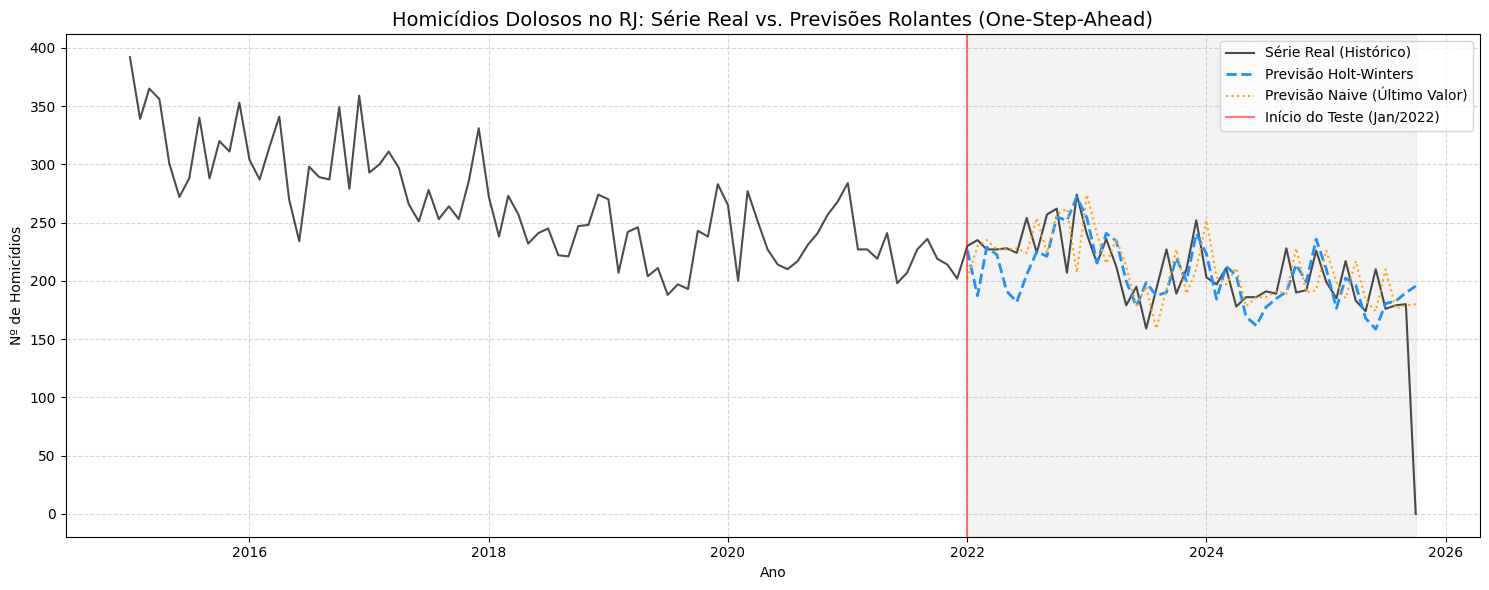

In [ ]:
# 1. Preparar os dados para plotagem
# Criamos uma Series para as previsões com o mesmo índice do período de teste
hw_series = pd.Series(preds_hw, index=datas_teste)
naive_series = pd.Series(preds_naive, index=datas_teste)

# 2. Configuração do Gráfico
plt.figure(figsize=(15, 6))

# Plotar a série real completa
plt.plot(serie_rj.index, serie_rj.values, label='Série Real (Histórico)', color='black', linewidth=1.5, alpha=0.7)

# Plotar as previsões (Iniciam em 2022)
plt.plot(hw_series.index, hw_series.values, label='Previsão Holt-Winters', color='dodgerblue', linestyle='--', linewidth=2)
plt.plot(naive_series.index, naive_series.values, label='Previsão Naive (Último Valor)', color='orange', linestyle=':', linewidth=1.5)

# 3. Estilização e Demarcação
# Linha vertical separando treino de teste (Início de 2022)
plt.axvline(pd.to_datetime(inicio_teste), color='red', linestyle='-', alpha=0.5, label='Início do Teste (Jan/2022)')

# Preencher a área de teste para destaque visual
plt.axvspan(pd.to_datetime(inicio_teste), serie_rj.index[-1], color='gray', alpha=0.1)

# Títulos e legendas
plt.title('Homicídios Dolosos no RJ: Série Real vs. Previsões Rolantes (One-Step-Ahead)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Nº de Homicídios')
plt.legend(loc='upper right')
plt.grid(True, which='major', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()